# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


## Описание данных

#### Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


#### Целевой признак
- Price — цена (евро)

## Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
print(data.shape)
data.info()

(354369, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int6

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


- Фотографиями никто делиться не захотел, столбец NumberOfPictures полностью заполнен нулями
- Часть значений в столбцах Price, Power и RegistrationMonth не указана (значение равно 0)
- В столбце RegistrationYear имеем странный разброс значений, минимальное равно 1000, максимальное - 9999
- Максимальное количество лошадиных сил в столбце Power равняется 20000, слишком много даже для самого мощного автомобиля в мире. Также в этом столбце есть строки со значением равным 0

Определим значимые признаки для постороения модели:

- VehicleType. Тип кузова автомобиля определяет его принадлежность к тому или определенному классу, также влияет на цену автомобиля, его эксплуатационные характеристики, перевозку грузов, проходимость
- Gearbox. Наличие автоматической коробки передач влияет на дороговизну ее изготовления, ремонта и эксплуатации
- Power. Мощность в лоашдиных силах (далее л.с.) напрямую влияют на цену.
- Kilometer. Имеет обратно пропорциональную зависиммость от цены. Чем больше километров проехала машина, тем меньше ее надежность и соответсвенно цена.
- FuelType. Тип топлива определяет конструкцию двигателя внутреннего сгорания.
- Brand. Концерн/компания, которая создала автомобиль показывает качество и надежность автомобиля.
- NotRepaired. Машины, которые побывали в дорожно-транспортных проишествиях означает, что машина подвергалась изменениям и ее надежность ниже.
- RegistrationYear. Год регистрации определяет сколько уже лет машина на ходу. Чем больше возраст, тем меньше цена.
- Model. Этот параметр также может влиять на популярность у покупателей.
- Price. Целевой признак

Остальные столбцы можем удалить

In [6]:
autos_data = data[['VehicleType', 
                         'Gearbox', 
                         'Power',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'NotRepaired',
                         'RegistrationYear',
                         'Model',
                         'Price']]
autos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   Gearbox           334536 non-null  object
 2   Power             354369 non-null  int64 
 3   Kilometer         354369 non-null  int64 
 4   FuelType          321474 non-null  object
 5   Brand             354369 non-null  object
 6   NotRepaired       283215 non-null  object
 7   RegistrationYear  354369 non-null  int64 
 8   Model             334664 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [7]:
autos_data['Price'].value_counts().head(10)

0       10772
500      5670
1500     5394
1000     4649
1200     4594
2500     4438
600      3819
3500     3792
800      3784
2000     3431
Name: Price, dtype: int64

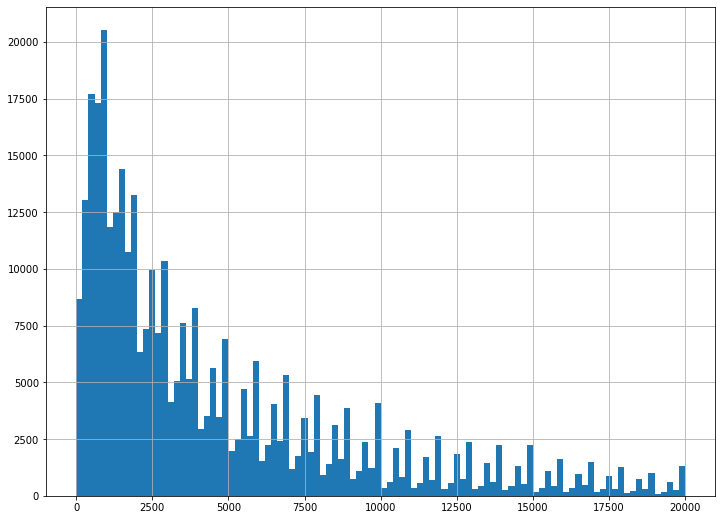

In [8]:
autos_data = autos_data.query('Price > 0')
autos_data['Price'].hist(bins=100, figsize=(12,9));

Выделим квантили 5% и 95%, чтобы избавиться от сильного разброса цен

In [9]:
autos_data['Price'].quantile([.05, 0.95])

0.05      350.0
0.95    14800.0
Name: Price, dtype: float64

350 евро это приблизительно 30 тысяч рублей - что в целом соответсвует цене подержанного автомобиля, 14800 евро ≈ 1,3 млн рублей - нормальная цена для качественного авто.

In [10]:
autos_data = autos_data.query('350 <= Price <= 14800')
autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310896 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       282232 non-null  object
 1   Gearbox           296772 non-null  object
 2   Power             310896 non-null  int64 
 3   Kilometer         310896 non-null  int64 
 4   FuelType          286177 non-null  object
 5   Brand             310896 non-null  object
 6   NotRepaired       253438 non-null  object
 7   RegistrationYear  310896 non-null  int64 
 8   Model             295807 non-null  object
 9   Price             310896 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 26.1+ MB


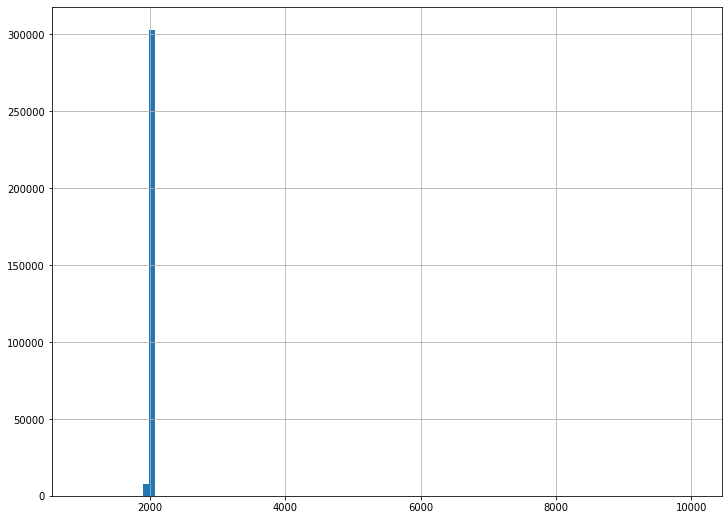

In [11]:
autos_data['RegistrationYear'].hist(bins=100, figsize=(12,9));

Наблюдаются выбросы. Отсечем правые выбросы, узнав максимальную дату скачивания анкеты автомобиля:

In [12]:
data['DateCrawled'].max()

'2016-04-07 14:36:58'

Даты регистрации после 2016 года некорректны и машины появились не раньше 1900 года. Отсечем ненужные года и промотрим левые выбросы.

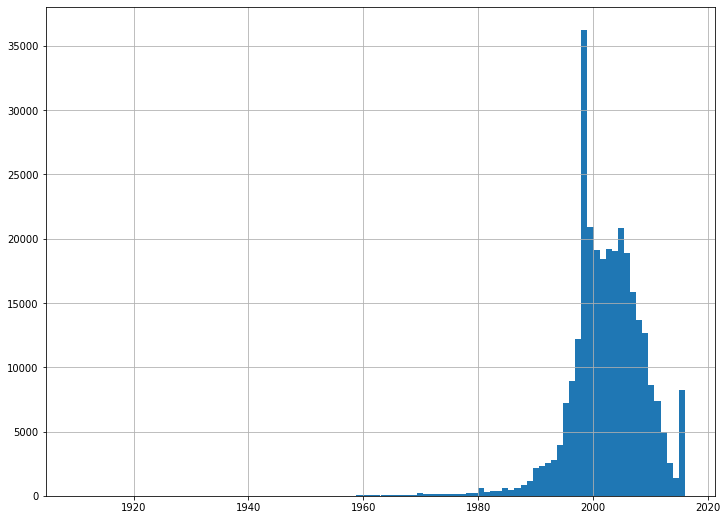

In [13]:
autos_data = autos_data.query('1899 < RegistrationYear < 2017')
autos_data['RegistrationYear'].hist(bins=100, figsize=(12,9));

Исходя из распределения минимальную границу RegistrationYear можем взять равной 1980, ниже 80-х - машины будут слишком старыми. Начиная от 1980 машины будут хоть и старыми, но еще работающими и пригодными для продажи

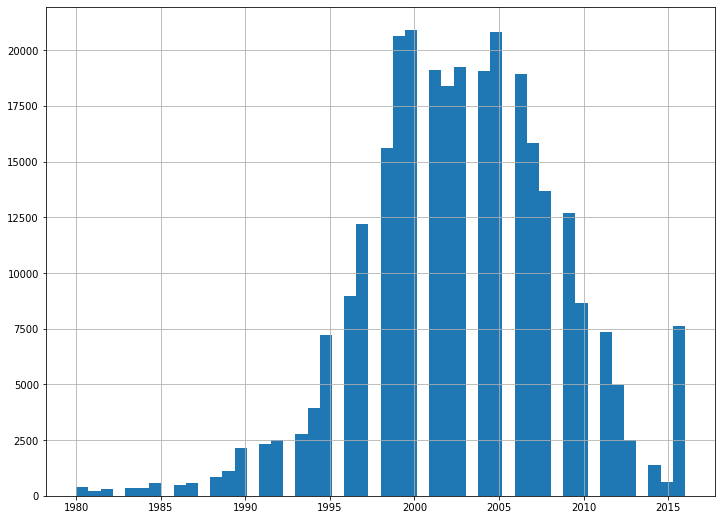

In [14]:
autos_data = autos_data.query('1979 < RegistrationYear < 2017')
autos_data['RegistrationYear'].hist(bins=50, figsize=(12,9));

Заменим пропуски в столбцах Gearbox, NotRepaired и Model:

- Для всех NaN в Gearbox установим значение 'manual'
- Для всех NaN в NotRepaired установим значение 'yes'
- Для всех NaN в Model установим значение 'unknown'

In [15]:
autos_data.fillna({'Gearbox':'manual', 
                           'NotRepaired':'yes',
                           'Model':'unknown'},
                          inplace=True)

В столбце VehicleType так же имеются пропуски, заменим их в соотвествии с популярным типом кузова для каждого бренда:

In [16]:

vehicle_type_pivot_table = autos_data.pivot_table(index=['VehicleType'], 
                                                        columns=['Brand'],
                                                        values=['Price'],
                                                        aggfunc=['count'])
display(vehicle_type_pivot_table)
autos_data[autos_data['Brand'] == 'alfa_romeo']['VehicleType'].value_counts()

count                                                     \
                 Price                                                      
Brand       alfa_romeo    audi      bmw chevrolet chrysler citroen  dacia   
VehicleType                                                                 
bus                NaN    10.0      5.0     144.0    394.0  1218.0   50.0   
convertible      149.0  1300.0   2667.0       9.0    218.0   106.0    NaN   
coupe            211.0  1007.0   3133.0      52.0     40.0   139.0    NaN   
other             11.0    95.0    203.0      31.0      8.0   102.0    6.0   
sedan            837.0  9737.0  15718.0     205.0    246.0   619.0  100.0   
small            221.0  1301.0    380.0     578.0     12.0  1460.0  221.0   
suv                NaN   101.0    620.0     301.0     18.0    29.0  199.0   
wagon            433.0  9710.0   7083.0     102.0    229.0   565.0  250.0   

                                     ...                          \
                                     ...                           
Brand       daewoo daihatsu    fiat  ...    seat   skoda   smart   
VehicleType                          ...                           
bus           26.0     31.0   776.0  ...   583.0   226.0     1.0   
convertible    1.0     17.0   441.0  ...     NaN     2.0  1112.0   
coupe          2.0      NaN   152.0  ...    70.0     3.0   334.0   
other          5.0      9.0   161.0  ...    53.0    22.0     9.0   
sedan         87.0     41.0   802.0  ...  1553.0   854.0    27.0   
small        247.0    442.0  4661.0  ...  2893.0  1078.0  3210.0   
suv            1.0     46.0    24.0  ...     3.0   119.0     NaN   
wagon         36.0     16.0   382.0  ...   343.0  2454.0     9.0   

                                                                             
                                                                             
Brand       sonstige_autos subaru suzuki  toyota trabant volkswagen   volvo  
VehicleType                                                                  
bus                  170.0   17.0   27.0   429.0     NaN     8389.0     NaN  
convertible          157.0    1.0   33.0    61.0    27.0     2487.0    65.0  
coupe                 88.0    4.0    6.0   197.0     2.0     1325.0    54.0  
other                160.0    5.0   12.0    16.0     4.0      645.0     2.0  
sedan                278.0  141.0  163.0   859.0   134.0    17860.0   562.0  
small                184.0   99.0  893.0  1563.0    38.0    16423.0     6.0  
suv                  305.0   55.0  721.0   389.0     1.0      875.0   152.0  
wagon                106.0  266.0   84.0   530.0    54.0    11693.0  1813.0  

[8 rows x 40 columns]

sedan          837
wagon          433
small          221
coupe          211
convertible    149
other           11
Name: VehicleType, dtype: int64

In [17]:
vehicle_type_pivot_table = vehicle_type_pivot_table['count']['Price']
vehicle_type_pivot_table

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,10.0,5.0,144.0,394.0,1218.0,50.0,26.0,31.0,776.0,...,583.0,226.0,1.0,170.0,17.0,27.0,429.0,NaN,8389.0,NaN
convertible,149.0,1300.0,2667.0,9.0,218.0,106.0,NaN,1.0,17.0,441.0,...,NaN,2.0,1112.0,157.0,1.0,33.0,61.0,27.0,2487.0,65.0
coupe,211.0,1007.0,3133.0,52.0,40.0,139.0,NaN,2.0,NaN,152.0,...,70.0,3.0,334.0,88.0,4.0,6.0,197.0,2.0,1325.0,54.0
other,11.0,95.0,203.0,31.0,8.0,102.0,6.0,5.0,9.0,161.0,...,53.0,22.0,9.0,160.0,5.0,12.0,16.0,4.0,645.0,2.0
sedan,837.0,9737.0,15718.0,205.0,246.0,619.0,100.0,87.0,41.0,802.0,...,1553.0,854.0,27.0,278.0,141.0,163.0,859.0,134.0,17860.0,562.0
small,221.0,1301.0,380.0,578.0,12.0,1460.0,221.0,247.0,442.0,4661.0,...,2893.0,1078.0,3210.0,184.0,99.0,893.0,1563.0,38.0,16423.0,6.0
suv,NaN,101.0,620.0,301.0,18.0,29.0,199.0,1.0,46.0,24.0,...,3.0,119.0,NaN,305.0,55.0,721.0,389.0,1.0,875.0,152.0
wagon,433.0,9710.0,7083.0,102.0,229.0,565.0,250.0,36.0,16.0,382.0,...,343.0,2454.0,9.0,106.0,266.0,84.0,530.0,54.0,11693.0,1813.0


Заполним словарь брендов и популярных типов машин и заполним пропуски по столбцу VehicleType

In [18]:
autos_data.fillna({'VehicleType':0},inplace=True)

def fillna_by_brand(row, row_number, vehicle_type_pivot_table):
    brand = row[5]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = vehicle_type_pivot_table[brand].idxmax()
    return fill_value

autos_data['VehicleType'] = autos_data.apply(
                            fillna_by_brand, 
                            args=[0, vehicle_type_pivot_table],
                            axis=1)
display(autos_data['VehicleType'].isna().sum())
autos_data['VehicleType'].value_counts()

0

sedan          89842
small          77474
wagon          58964
bus            26444
convertible    17247
coupe          12913
suv             9696
other           2663
Name: VehicleType, dtype: int64

По похожему принципу заполним пропуски в FuelType

In [19]:
autos_data['FuelType'].value_counts()
fuel_type_pivot_table = autos_data.pivot_table(index=['FuelType'], 
                                               columns=['Brand'],
                                               values=['Price'],
                                               aggfunc=['count'])

fuel_type_pivot_table = fuel_type_pivot_table['count']['Price']
display(fuel_type_pivot_table)

autos_data.fillna({'FuelType':0},inplace=True)

autos_data['FuelType'] = autos_data.apply(fillna_by_brand, 
                                          args=[4, vehicle_type_pivot_table],
                                          axis=1)

display(autos_data['FuelType'].isna().sum())
autos_data['FuelType'].value_counts()

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
FuelType,,,,,,,,,,,,,,,,,,,,,
cng,NaN,1.0,7.0,4.0,NaN,7.0,2.0,NaN,NaN,65.0,...,2.0,6.0,2.0,7.0,2.0,NaN,NaN,NaN,172.0,20.0
electric,NaN,2.0,3.0,NaN,NaN,1.0,NaN,NaN,1.0,4.0,...,NaN,NaN,3.0,21.0,NaN,NaN,NaN,NaN,1.0,NaN
gasoline,564.0,10430.0,9891.0,198.0,353.0,1471.0,197.0,1.0,4.0,1356.0,...,1518.0,1681.0,841.0,398.0,31.0,211.0,901.0,1.0,22372.0,892.0
hybrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,1.0,NaN,1.0,11.0,NaN,NaN,89.0,NaN,5.0,NaN
lpg,31.0,433.0,716.0,169.0,92.0,63.0,50.0,23.0,5.0,63.0,...,60.0,51.0,3.0,92.0,29.0,22.0,23.0,NaN,501.0,102.0
other,NaN,1.0,5.0,NaN,NaN,2.0,NaN,1.0,NaN,2.0,...,NaN,NaN,1.0,10.0,NaN,1.0,NaN,25.0,14.0,2.0
petrol,1255.0,12036.0,18516.0,1019.0,700.0,2661.0,556.0,374.0,582.0,5827.0,...,3886.0,2954.0,3819.0,855.0,508.0,1675.0,3007.0,195.0,36318.0,1581.0


0

petrol         184965
gasoline        85266
sedan           10109
small            8231
lpg              4832
cng               513
wagon             436
suv               428
hybrid            169
other             106
bus                82
electric           76
convertible        30
Name: FuelType, dtype: int64

In [20]:
autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295243 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       295243 non-null  object
 1   Gearbox           295243 non-null  object
 2   Power             295243 non-null  int64 
 3   Kilometer         295243 non-null  int64 
 4   FuelType          295243 non-null  object
 5   Brand             295243 non-null  object
 6   NotRepaired       295243 non-null  object
 7   RegistrationYear  295243 non-null  int64 
 8   Model             295243 non-null  object
 9   Price             295243 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 24.8+ MB


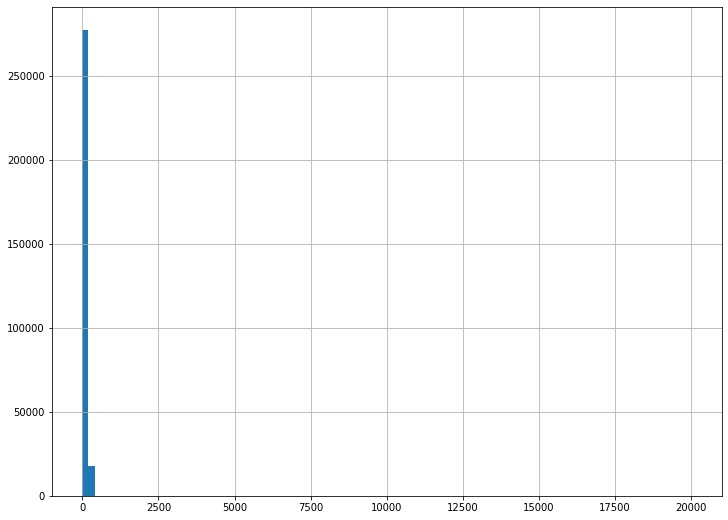

In [21]:
autos_data['Power'].hist(bins=100, figsize=(12,9));

Раброс очень сильный, исключим выбросы больше 1000 л.с.

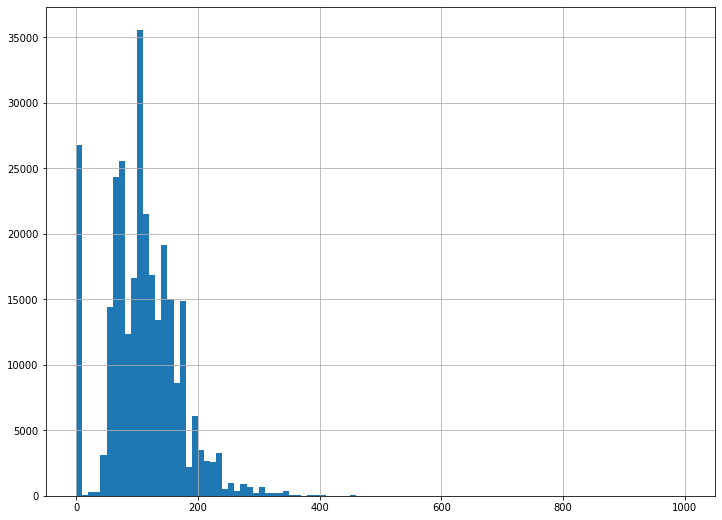

In [22]:
autos_data = autos_data.query('Power < 1001')
autos_data['Power'].hist(bins=100, figsize=(12,9));

Видим из распределения, что многие машины имеют мощность равную 0. Эти строки можем исключить. За минимальное значение мощности возьмем - 25, максимальным значением мощности выберем 350 л.с.

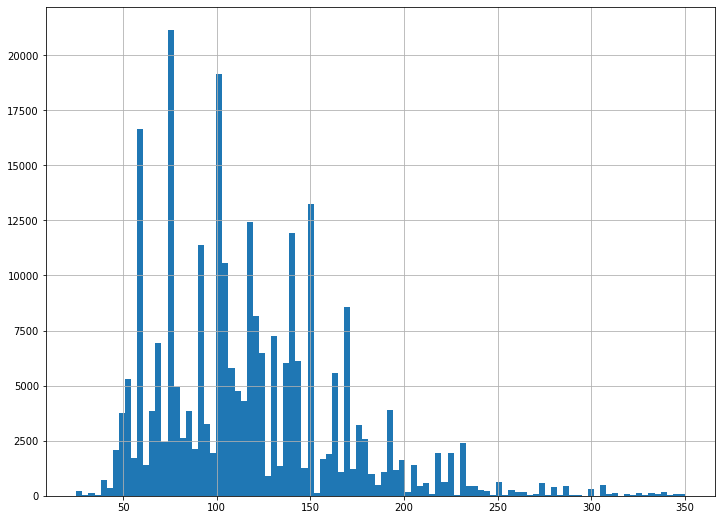

In [23]:
autos_data = autos_data.query('24 < Power < 351')
autos_data['Power'].hist(bins=100, figsize=(12,9));

In [24]:
autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267647 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       267647 non-null  object
 1   Gearbox           267647 non-null  object
 2   Power             267647 non-null  int64 
 3   Kilometer         267647 non-null  int64 
 4   FuelType          267647 non-null  object
 5   Brand             267647 non-null  object
 6   NotRepaired       267647 non-null  object
 7   RegistrationYear  267647 non-null  int64 
 8   Model             267647 non-null  object
 9   Price             267647 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 22.5+ MB


Значения в столбцах Gearbox и NotRepaired переведем на булев тип:

- IsManualGearbox. 1(manual) - означает механическую коробку передач. 0(auto) - автоматическую.
- IsNotRepaired. 1(yes) - означает машину без ремонта. 0(no) - с ремонтом.

In [25]:
autos_data['IsManualGearbox'] = 0
autos_data.loc[autos_data['Gearbox'] == 'manual', 'IsManualGearbox'] = 1
print(autos_data['IsManualGearbox'].value_counts())
autos_data['Gearbox'].value_counts()

1    217601
0     50046
Name: IsManualGearbox, dtype: int64


manual    217601
auto       50046
Name: Gearbox, dtype: int64

In [26]:
autos_data['IsNotRepaired'] = 0
autos_data.loc[autos_data['NotRepaired'] == 'yes', 'IsNotRepaired'] = 1
print(autos_data['IsNotRepaired'].value_counts())
autos_data['NotRepaired'].value_counts()

0    204994
1     62653
Name: IsNotRepaired, dtype: int64


no     204994
yes     62653
Name: NotRepaired, dtype: int64

In [27]:
autos_data.drop(['NotRepaired','Gearbox'], inplace=True, axis=1)

In [28]:
autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267647 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       267647 non-null  object
 1   Power             267647 non-null  int64 
 2   Kilometer         267647 non-null  int64 
 3   FuelType          267647 non-null  object
 4   Brand             267647 non-null  object
 5   RegistrationYear  267647 non-null  int64 
 6   Model             267647 non-null  object
 7   Price             267647 non-null  int64 
 8   IsManualGearbox   267647 non-null  int64 
 9   IsNotRepaired     267647 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 22.5+ MB


## Обучение моделей

Обучим разные модели и для каждой попробуем различные гиперпараметры.
Проанализируем скорость работы и качество моделей, для оценки качества моделей будем применять метрики MSE и RMSE.



Подготовим три типа признаков для кроссвалидации:

- Неизмененные. Название original_features.
- Закодированные методом OHE. Название ohe_features.
- Закодированные методом OE. Название oe_features.

In [29]:
#Неизмененные принаки
original_features = autos_data.drop('Price', axis=1)

#Прямое кодирование
encoder = OrdinalEncoder()
cat_columns = ['VehicleType','FuelType','Brand','Model']
cat_features = original_features[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
oe_features = original_features.copy()
for column in cat_columns:
    oe_features[column] = cat_features[column]

#Кодирование методом OHE
ohe_features = pd.get_dummies(original_features, drop_first=True)

#Целевой признак
target = autos_data['Price']

In [30]:
original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, target, test_size=0.25, random_state=12345)

oe_features_train = oe_features.loc[original_features_train.index, :]
oe_features_test = oe_features.loc[original_features_test.index, :]

ohe_features_train = ohe_features.loc[original_features_train.index, :]
ohe_features_test = ohe_features.loc[original_features_test.index, :]

Выберем следующие регрессоры для обучения модели:

- LinearRegression
- DecisionTreeRegressor
- CatBoostRegressor
- LGBMRegressor

### LinearRegression

In [31]:
%%time

regressor = LinearRegression()
cv_RMSE_LR = (cross_val_score(regressor, 
                             ohe_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Среднее значение RMSE для LinearRegression =', cv_RMSE_LR)
print()

Среднее значение RMSE для LinearRegression = 2022.5677906897365

CPU times: user 51.9 s, sys: 52.4 s, total: 1min 44s
Wall time: 1min 44s


### DecisionTreeRegressor

1.  Обучим модель на признаках, закодированных по методу OHE.
2.  Обучим модель на признаках, закодированных по методу OE.

In [32]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Лучшие параметры:")
print()
print(clf.best_params_)

means = clf.cv_results_['mean_test_score']
print()

cv_RMSE_DTR_ohe = (max(means)*-1) ** 0.5
print('Среднее значение RMSE для DecisionTreeRegressor =', round(cv_RMSE_DTR_ohe, 3)) 
print()

Лучшие параметры:

{'criterion': 'mse', 'max_depth': 18, 'random_state': 12345}

Среднее значение RMSE для DecisionTreeRegressor = 1525.939

CPU times: user 7min 47s, sys: 32 s, total: 8min 19s
Wall time: 8min 19s


In [33]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(oe_features_train, target_train)
print("Лучшие параметры:")
print()
print(clf.best_params_)

means = clf.cv_results_['mean_test_score']

print()
cv_RMSE_DTR_oe = (max(means)*-1) ** 0.5
print('Среднее значение RMSE для DecisionTreeRegressor =', round(cv_RMSE_DTR_oe,3))
print()

Лучшие параметры:

{'criterion': 'mse', 'max_depth': 14, 'random_state': 12345}

Среднее значение RMSE для DecisionTreeRegressor = 1544.253

CPU times: user 50.1 s, sys: 513 ms, total: 50.6 s
Wall time: 50.7 s


Результат обучения DecisionTreeRegressor на OHE схож с результатом обчения с помощью порядкового кодирования. Для дальнейшего обучения будем использовать оба этих результата

### CatBoostRegressor

1. Обучим модель на данных, закодированных по методу OE.
2. Обучим модель на оригинальных данных с указанием категорий.

In [34]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[12345],
                'verbose':[False]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(oe_features_train, target_train)
print("Лучшие параметры:")
print()
print(clf.best_params_)

means = clf.cv_results_['mean_test_score']

print()

cv_RMSE_CBR_oe = (max(means)*-1) ** 0.5
print('Среднее значение RMSE для CatBoostRegressor =', round(cv_RMSE_CBR_oe, 3))
print()

Лучшие параметры:

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}

Среднее значение RMSE для CatBoostRegressor = 1306.837

CPU times: user 5min 40s, sys: 2.89 s, total: 5min 43s
Wall time: 6min


In [35]:
%%time

regressor = CatBoostRegressor(learning_rate=0.5,
                              iterations = 200,
                              random_state=12345, 
                              verbose=False, 
                              cat_features=['VehicleType','FuelType','Brand','Model']) 

cv_RMSE_CBR_original = (cross_val_score(regressor,
                                original_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print('Среднее значение RMSE для CatBoostRegressorr =', round(cv_RMSE_CBR_original, 3))
print()

Среднее значение RMSE для CatBoostRegressorr = 1343.345

CPU times: user 1min 45s, sys: 741 ms, total: 1min 46s
Wall time: 1min 48s


### LGBMRegressor

In [36]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(oe_features_train, target_train)
print("Лучшие параметры:")
print()
print(clf.best_params_)
print()

means = clf.cv_results_['mean_test_score']

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5
print('Среднее значение RMSE для LGBMRegressor =', round(cv_RMSE_LGBMR, 3))
print()

Лучшие параметры:

{'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345}

Среднее значение RMSE для LGBMRegressor = 1304.854

CPU times: user 1h 4min 59s, sys: 31.5 s, total: 1h 5min 31s
Wall time: 1h 5min 56s


### Вывод
- Изучили следующие регрессионные модели:
    - LinearRegression
    - DecisionTreeRegressor
    - CatBoostRegressor
    - LGBMRegressor
- Рассчитали лучшие гиперпараметры и время их выполнения

## Анализ моделей

Теперь проведем обучение каждой модели с лучшими гиперпараметрами

### LinearRegression

In [37]:
%%time

model = LinearRegression()
model.fit(ohe_features_train, target_train)

CPU times: user 13.6 s, sys: 15.2 s, total: 28.8 s
Wall time: 28.8 s


LinearRegression()

In [38]:
%%time

target_predict = model.predict(ohe_features_test)

CPU times: user 98.9 ms, sys: 163 ms, total: 262 ms
Wall time: 220 ms


In [39]:
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5
print(final_RMSE_LR)

2013.0563532548772


### DecisionTreeRegressor

In [40]:
%%time

model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=17, 
                              random_state=12345) 
model.fit(ohe_features_train, target_train)

CPU times: user 4.59 s, sys: 183 ms, total: 4.77 s
Wall time: 4.77 s


DecisionTreeRegressor(max_depth=17, random_state=12345)

In [41]:
%%time

target_predict = model.predict(ohe_features_test)

CPU times: user 56.6 ms, sys: 77.9 ms, total: 134 ms
Wall time: 136 ms


In [42]:
final_RMSE_DTR_ohe = mean_squared_error(target_test, target_predict) ** 0.5
print(final_RMSE_DTR_ohe)

1495.4061299016794


In [43]:
%%time

model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=13, 
                              random_state=12345) 
model.fit(oe_features_train, target_train)

CPU times: user 378 ms, sys: 4 ms, total: 382 ms
Wall time: 392 ms


DecisionTreeRegressor(max_depth=13, random_state=12345)

In [44]:
%%time

target_predict = model.predict(oe_features_test)

CPU times: user 11.4 ms, sys: 1.63 ms, total: 13 ms
Wall time: 11.3 ms


In [45]:
final_RMSE_DTR_oe = mean_squared_error(target_test, target_predict) ** 0.5
print(final_RMSE_DTR_oe)

1515.2862480920817


### CatBoostRegressor

In [46]:
%%time

model = CatBoostRegressor(learning_rate=0.5, 
                          random_state=12345, 
                          verbose=False) 
model.fit(oe_features_train, target_train)

CPU times: user 23.4 s, sys: 164 ms, total: 23.5 s
Wall time: 25.5 s


In [47]:
%%time

target_predict = model.predict(oe_features_test)

CPU times: user 59.7 ms, sys: 34 µs, total: 59.7 ms
Wall time: 58.4 ms


In [48]:
final_RMSE_CBR_oe = mean_squared_error(target_test, target_predict) ** 0.5
print(final_RMSE_CBR_oe)

1287.2555670811391


In [49]:
%%time

model = CatBoostRegressor(learning_rate=0.5, 
                          iterations = 200, 
                          random_state=12345, 
                          verbose=False,
                          cat_features=['VehicleType','FuelType','Brand','Model']) 
model.fit(original_features_train, target_train)

CPU times: user 25.8 s, sys: 182 ms, total: 26 s
Wall time: 26.7 s


In [50]:
%%time

target_predict = model.predict(original_features_test)

CPU times: user 130 ms, sys: 48 µs, total: 131 ms
Wall time: 136 ms


In [51]:
final_RMSE_CBR_original = mean_squared_error(target_test, target_predict) ** 0.5
print(final_RMSE_CBR_original)

1324.5429490000374


### LGBMRegressor

In [52]:
%%time

model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=12345)
model.fit(oe_features_train, target_train)

CPU times: user 1min 46s, sys: 896 ms, total: 1min 47s
Wall time: 1min 47s


LGBMRegressor(num_leaves=200, random_state=12345)

In [53]:
%%time

target_predict = model.predict(oe_features_test)

CPU times: user 677 ms, sys: 0 ns, total: 677 ms
Wall time: 615 ms


In [54]:
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5
print(final_RMSE_LGBMR)

1290.0019030027977


Для удобного сравнения занесем все результаты обучения и анализа моделей в таблицу:

In [55]:
index = ['LinearRegression',
         'DecisionTreeRegressor on OHE features',
         'DecisionTreeRegressor on OE features',
         'CatBoostRegressor on OE features',
         'CatBoostRegressor on original features',
         'LGBMRegressor']
data = {'RMSE на CV, евро':[cv_RMSE_LR,
                            cv_RMSE_DTR_ohe,
                            cv_RMSE_DTR_oe,
                            cv_RMSE_CBR_oe,
                            cv_RMSE_CBR_original,
                            cv_RMSE_LGBMR],
        'Время обучения на CV, сек':[89,
                                     354,
                                     37.1,
                                     1065,
                                     431,
                                     249],
        'RMSE модели на тестовой выборке, евро':[final_RMSE_LR,
                                                final_RMSE_DTR_ohe,
                                                final_RMSE_DTR_oe,
                                                final_RMSE_CBR_oe,
                                                final_RMSE_CBR_original,
                                                final_RMSE_LGBMR],
        'Время обучения модели, сек':[22,
                                      6,
                                      0.545,
                                      139,
                                      105,
                                      15.2],
        'Время предсказания модели, сек':[0.285,
                                          0.156,
                                          0.019,
                                          0.153,
                                          0.322,
                                          1.37]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE'] = (scores_data['RMSE на CV, евро'].min() /
                              scores_data['RMSE на CV, евро'])
scores_data['Рейтинг времени обучения'] = (scores_data['Время обучения модели, сек'].min() / 
                              scores_data['Время обучения модели, сек'])
scores_data['Рейтинг времени предсказания'] = (scores_data['Время предсказания модели, сек'].min() / 
                              scores_data['Время предсказания модели, сек'])
scores_data['Итоговый рейтинг'] = (scores_data['Рейтинг RMSE'] +
                                   scores_data['Рейтинг времени обучения'] +
                                   scores_data['Рейтинг времени предсказания'])
scores_data

,"RMSE на CV, евро","Время обучения на CV, сек","RMSE модели на тестовой выборке, евро","Время обучения модели, сек","Время предсказания модели, сек",Рейтинг RMSE,Рейтинг времени обучения,Рейтинг времени предсказания,Итоговый рейтинг
LinearRegression,2022.567791,89.0,2013.056353,22.000,0.285,0.645147,0.024773,0.066667,0.736587
DecisionTreeRegressor on OHE features,1525.938995,354.0,1495.406130,6.000,0.156,0.855115,0.090833,0.121795,1.067744
DecisionTreeRegressor on OE features,1544.253487,37.1,1515.286248,0.545,0.019,0.844974,1.000000,1.000000,2.844974
CatBoostRegressor on OE features,1306.836660,1065.0,1287.255567,139.000,0.153,0.998483,0.003921,0.124183,1.126587
CatBoostRegressor on original features,1343.345301,431.0,1324.542949,105.000,0.322,0.971347,0.005190,0.059006,1.035543
LGBMRegressor,1304.853948,249.0,1290.001903,15.200,1.370,1.000000,0.035855,0.013869,1.049724


## Вывод

1. Изучили и подготовили данные к анализу:
    - Значения RegistrationYear взяты от 1980 до 2016 гг
    - Значения Power от 25 до 350 л.с
    - Определили значимые признаки для постороения модели
    - Заполнили пропуски в столбцах и удалили некорректные значения
    - Признаки Gearbox и NotRepaired перевели на булев тип

2. Выполнили сравнение моделей с использованием различных наборов гиперпараметров. 
3. Лучшей моделью по трем параметрам: качество, скорость обучения и скорость предсказания можно считать DecisionTreeRegressor. 
4. Если рассматривать только точность, то лучшая модель - LGBMRegressor, на втором месте - CatBoostRegressor и на третьем - DecisionTreeRegressor, линейная регрессия показала худший результат

- Для задач, требующих высокой точности без акцента на скорость выполнения, хороший результат покажут модели LGBMRegressor и CatBoostRegressor.
- Для быстрых решений с хорошей точностью подойдет DecisionTreeRegressor